In [ ]:
import os

import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

cwd = os.getcwd()
cwd
benchmark_result_path = os.path.realpath(
  os.path.join(cwd, "../data/realworld-results.csv")
)
benchmark_result_path

In [38]:
# Load the dataset
csv_headers = ["framework", "os", "browser", "metric", "rating", "value"]
df = pd.read_csv(benchmark_result_path, header=None, names=csv_headers)

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_framework = df.groupby("framework")
df_by_metric = df.groupby("metric")

# Display basic info
pd.concat([df.head(5), df.tail(5)])

,framework,os,browser,metric,rating,value
0,realworld-angular,darwin,chromium,TTFB,good,6.3
1,realworld-angular,darwin,chromium,FCP,good,52.0
2,realworld-angular,darwin,chromium,FID,good,1.6
3,realworld-angular,darwin,chromium,LCP,good,80.0
4,realworld-angular,darwin,chromium,TTFB,good,3.6
116875,realworld-vue,win32,webkit,FCP,good,362.0
116876,realworld-vue,win32,webkit,TTFB,good,3.0
116877,realworld-vue,win32,webkit,FCP,good,389.0
116878,realworld-vue,win32,webkit,TTFB,good,3.0
116879,realworld-vue,win32,webkit,FCP,good,395.0


In [39]:
# Validate

# Check if there is sufficient data for ANOVA
if (
  df["framework"].nunique() < 0
  or df["browser"].nunique() < 0
  or df["os"].nunique() < 0
):
  raise Exception(f"Metric {metric} has insufficient data.")

# Group by all factors and count the number of observations
counts = (
  df.groupby(["framework", "metric", "browser", "os"])
  .size()
  .reset_index(name="count")
)
single_observations = counts[counts["count"] == 1]

if not single_observations.empty:
  print("WARNING: The following groups have only one observation. ANOVA may fail:")
  print(single_observations)
  raise Exception("Consider combining levels or simplifying your model.")

######################################################################
ANOVA Results for Metric: FCP
######################################################################
                   df        sum_sq       mean_sq           F         PR(>F)
C(framework)      3.0  2.153085e+07  7.176948e+06  452.422952  1.426709e-288
Residual      35994.0  5.709858e+08  1.586336e+04         NaN            NaN
______________________________________________________________________
count    35998.000000
mean       168.335921
std        128.297184
min         32.000000
25%         72.000000
50%        104.200000
75%        290.000000
max       1333.000000
Name: value, dtype: float64



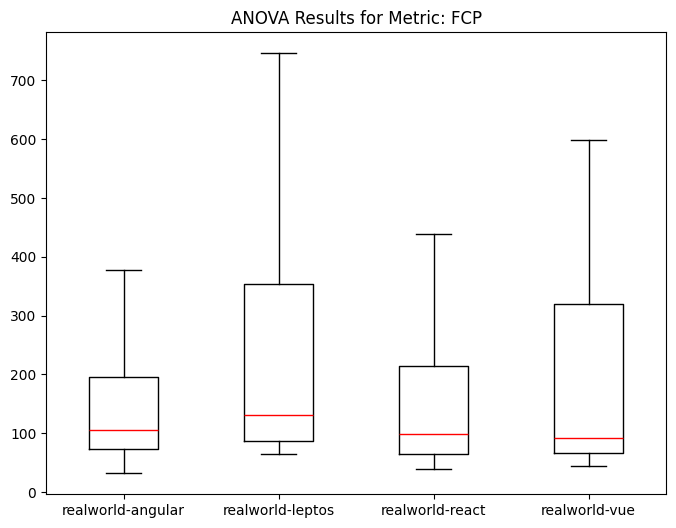

######################################################################
ANOVA Results for Metric: FID
######################################################################
                   df       sum_sq     mean_sq           F         PR(>F)
C(framework)      3.0   480.756258  160.252086  434.660263  1.213077e-274
Residual      22828.0  8416.307925    0.368684         NaN            NaN
______________________________________________________________________
count    22832.000000
mean         1.002527
std          0.624253
min          0.000000
25%          0.800000
50%          1.000000
75%          1.200000
max          7.600000
Name: value, dtype: float64



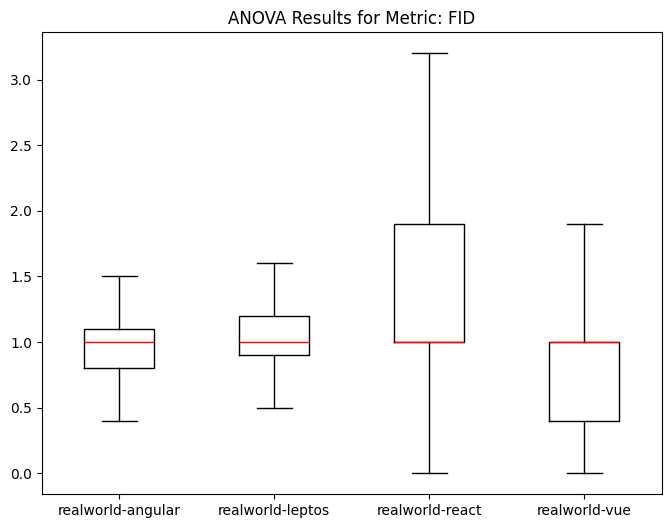

######################################################################
ANOVA Results for Metric: LCP
######################################################################
                   df        sum_sq       mean_sq           F         PR(>F)
C(framework)      3.0  2.058840e+07  6.862799e+06  403.719099  2.405049e-255
Residual      22118.0  3.759827e+08  1.699894e+04         NaN            NaN
______________________________________________________________________
count    22122.000000
mean       211.138509
std        133.893079
min         46.000000
25%         92.000000
50%        158.500000
75%        340.225000
max       1173.000000
Name: value, dtype: float64



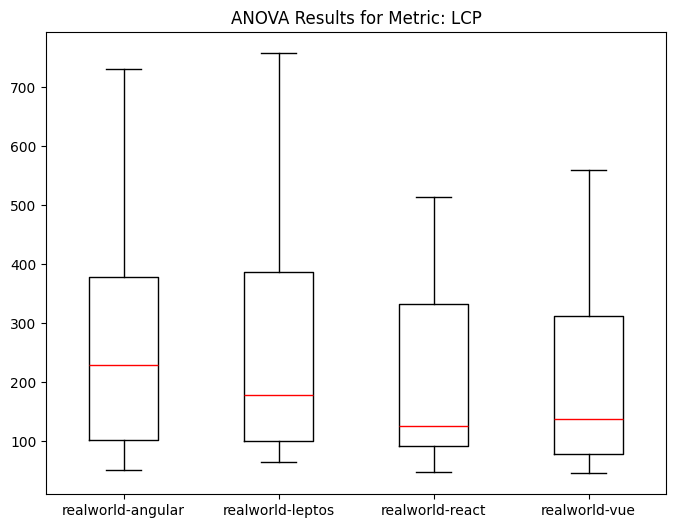

######################################################################
ANOVA Results for Metric: TTFB
######################################################################
                   df        sum_sq     mean_sq         F    PR(>F)
C(framework)      3.0  3.802469e+02  126.748970  0.691011  0.557394
Residual      35924.0  6.589375e+06  183.425417       NaN       NaN
______________________________________________________________________
count    35928.000000
mean         9.394007
std         13.543289
min          1.000000
25%          2.100000
50%          4.000000
75%          9.000000
max        113.000000
Name: value, dtype: float64



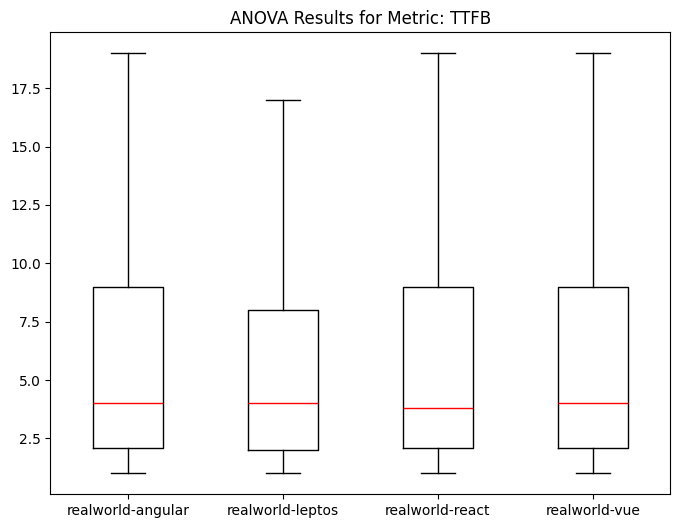

In [40]:
# Initialize a results dictionary
anova_results = {}

for metric, group_df in df_by_metric:
  # Perform ANOVA for the metric
  model = ols("value ~ C(framework)", data=group_df).fit()
  anova_results[metric] = sm.stats.anova_lm(model, typ=1)

  p_value = 0
  mean = group_df['value'].describe()

  # Init a figure and axes
  fig, ax = plt.subplots(figsize=(8, 6))

  # [group['value'].values for name, group in df_by_metric],
  boxplot = ax.boxplot(x=[group[group['metric'] == metric]['value'].values for name, group in df_by_framework],
                       tick_labels=frameworks,
                       #patch_artist=True,
                       showfliers=False,
                       medianprops={'color': 'red'}
                       )

  print("######################################################################")
  ax.set_title(f"ANOVA Results for Metric: {metric}")
  print(f"ANOVA Results for Metric: {metric}")
  print("######################################################################")
  print(anova_results[metric])
  print("______________________________________________________________________")
  print(mean)
  print("")

  plt.show()

######################################################################
Tukey Results for Metric: FCP
######################################################################
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1           group2      meandiff p-adj   lower    upper   reject
---------------------------------------------------------------------------
realworld-angular realworld-leptos  83.0425   0.0   78.3149    87.77   True
realworld-angular  realworld-react -12.8453   0.0  -17.8993  -7.7914   True
realworld-angular    realworld-vue   9.0843   0.0    4.0304  14.1383   True
 realworld-leptos  realworld-react -95.8878   0.0 -100.6151 -91.1605   True
 realworld-leptos    realworld-vue -73.9581   0.0  -78.6854 -69.2308   True
  realworld-react    realworld-vue  21.9296   0.0    16.876  26.9833   True
---------------------------------------------------------------------------
####################################################################

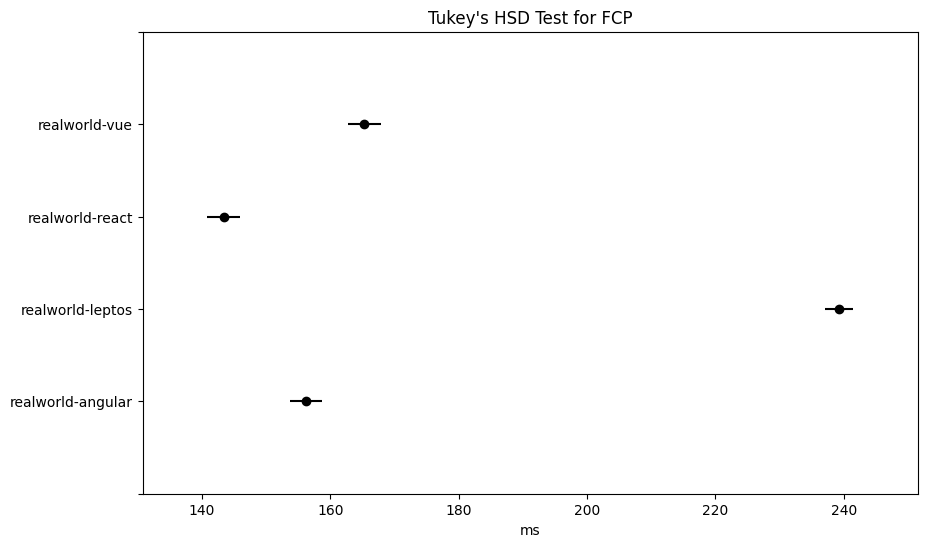

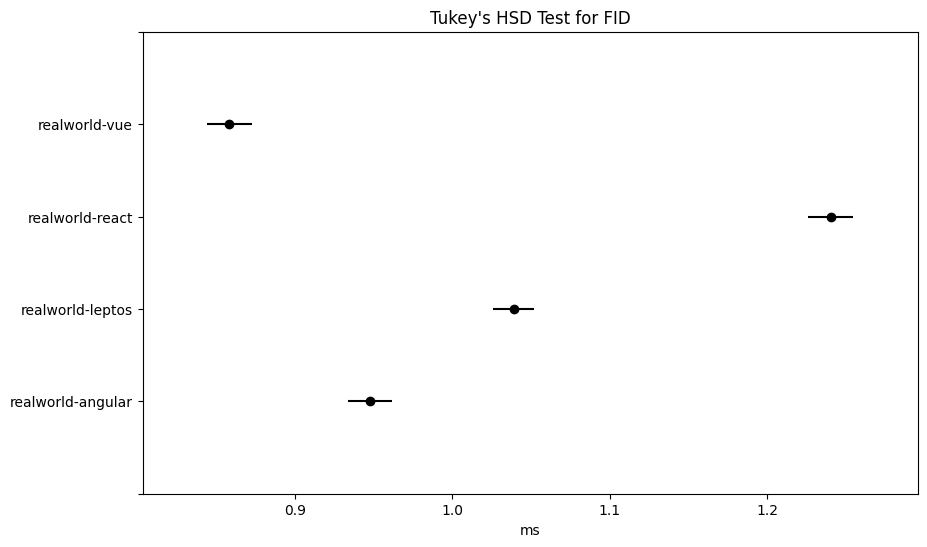

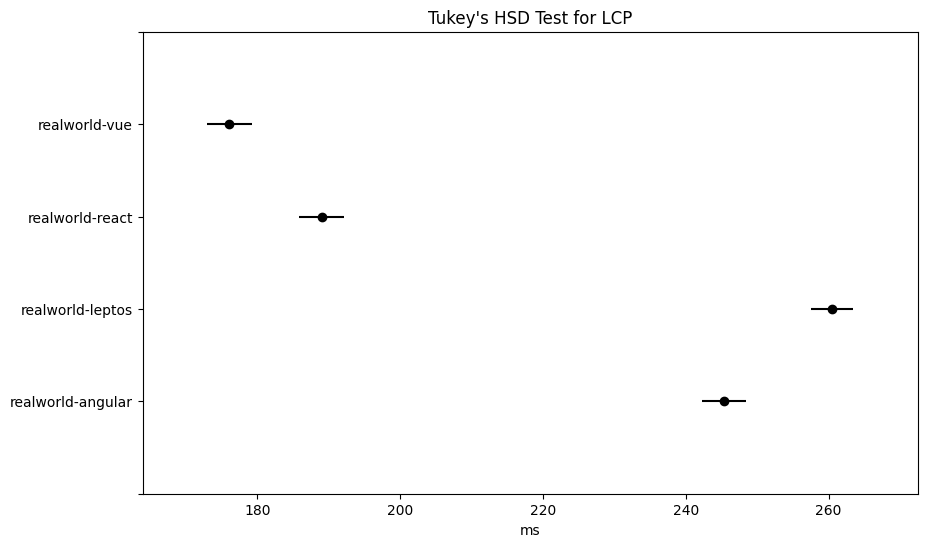

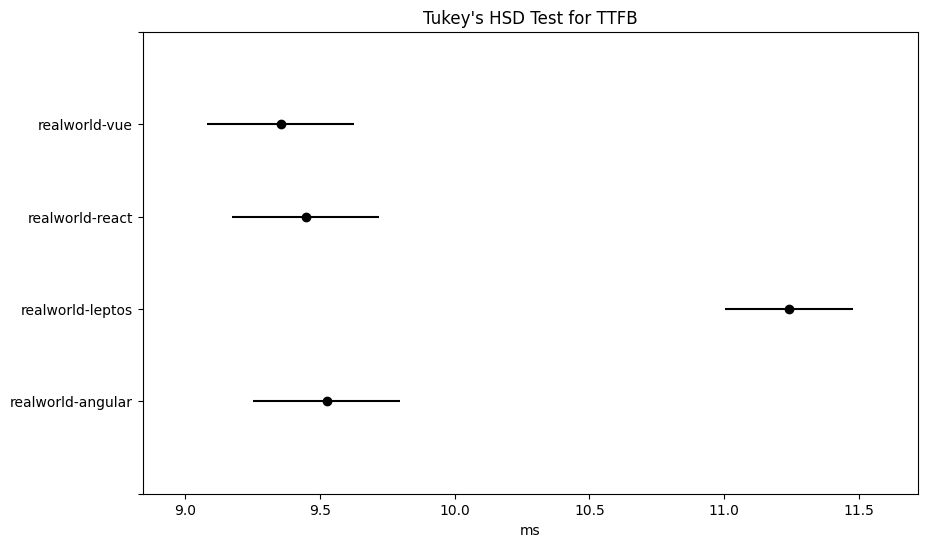

In [6]:
alpha = 0.05

for metric, group_df in df_by_metric:
  endog = group_df["value"]  # Data
  groups = group_df["framework"]  # Groups

  tukey = pairwise_tukeyhsd(endog, groups, alpha)

  print("######################################################################")
  print(f"Tukey Results for Metric: {metric}")
  print("######################################################################")
  print(tukey.summary())

  # Plot group confidence intervals
  fig, ax = plt.subplots(figsize=(1, 1))
  tukey.plot_simultaneous(ax=ax, xlabel="ms")
  # plt.vlines(x=50, ymin=-0.5, ymax=4.5, color="red")

  ax.set_title(f"Tukey's HSD Test for {metric}")

  fig.savefig(f"output/tukey_hsd_{metric}.pdf")

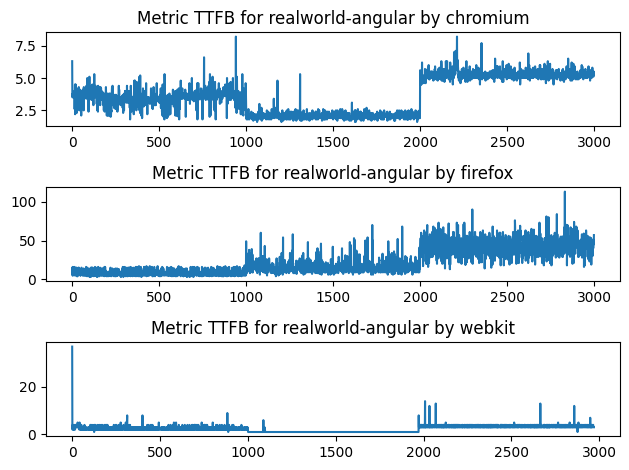

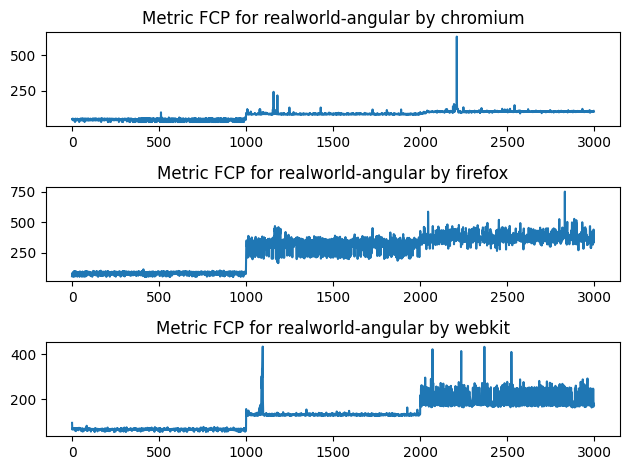

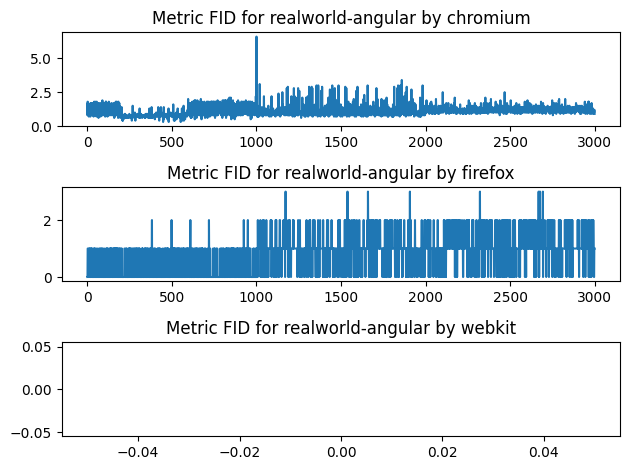

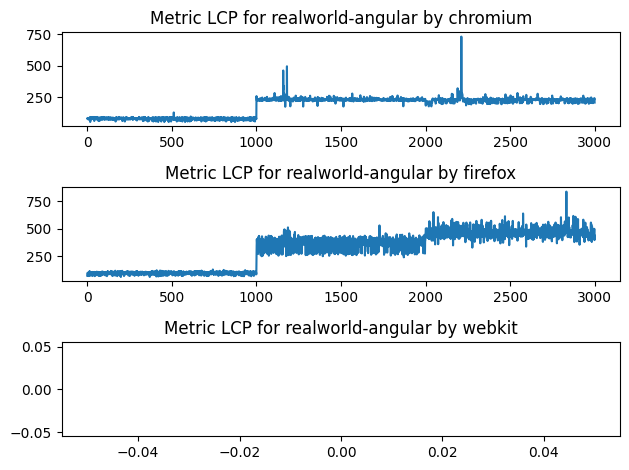

In [82]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

metric = "TTFB"
framework = "realworld-angular"

#
#    for framework in frameworks:

for metric in metrics:
  fig, axs = plt.subplots(len(browsers))
  for i, browser in enumerate(browsers):
    axs[i].set_title(f"Metric {metric} for {framework} by {browser}")
    xy = df
    #xy = xy[xy['os'] == 'win32']
    xy = xy[xy['metric'] == metric]
    xy = xy[xy['framework'] == framework]
    xy = xy[xy['browser'] == browser]
    xy = xy.reset_index()["value"]

    axs[i].plot(xy)

  fig.tight_layout()
  plt.show()